In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.5 MB/s eta 0:00:00


In [ ]:
import tensorflow_text as text

In [ ]:
import pandas as pd

df = pd.read_csv("text.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
#Downsampling ham to be same size as spam
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
#Balanced dataset after imbalance is resolved
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [ ]:
#Assigning binary values to spam check
df_balanced['spam_check']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam_check
160,spam,You are a winner U have been specially selecte...,1
3840,ham,Erm … ill pick you up at about 6.45pm. That'll...,0
2906,ham,Ha. You don‘t know either. I did a a clever bu...,0
962,spam,URGENT! We are trying to contact U. Todays dra...,1
3435,ham,Sending you greetings of joy and happiness. Do...,0


In [ ]:
#Splitting it into training and test data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam_check'], stratify=df_balanced['spam_check'])


In [ ]:
#Importing bert model
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
import tensorflow as tf

In [ ]:
# Building the bert network layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer
preprocessed_text = bert_preprocess(text_input) # passing the input into bert
outputs = bert_encoder(preprocessed_text) # output layer

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) #dropout is used to reduce overfitting 
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# constructing a final model using input and output above
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [33]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 569s 16s/step - loss: 0.6983 - accuracy: 0.5589 - precision: 0.5594 - recall: 0.5554
Epoch 2/10
35/35 [==============================] - 548s 16s/step - loss: 0.5367 - accuracy: 0.7955 - precision: 0.7791 - recall: 0.8250
Epoch 3/10
35/35 [==============================] - 546s 16s/step - loss: 0.4790 - accuracy: 0.8223 - precision: 0.7964 - recall: 0.8661
Epoch 4/10
35/35 [==============================] - 541s 15s/step - loss: 0.4260 - accuracy: 0.8536 - precision: 0.8438 - recall: 0.8679
Epoch 5/10
35/35 [==============================] - 526s 15s/step - loss: 0.3814 - accuracy: 0.8696 - precision: 0.8545 - recall: 0.8911
Epoch 6/10
35/35 [==============================] - 529s 15s/step - loss: 0.3583 - accuracy: 0.8786 - precision: 0.8605 - recall: 0.9036
Epoch 7/10
35/35 [==============================] - 526s 15s/step - loss: 0.3326 - accuracy: 0.8893 - precision: 0.8695 - recall: 0.9161
Epoch 8/10
35/35 [=======================

In [34]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 182s 15s/step - loss: 0.3038 - accuracy: 0.9011 - precision: 0.8989 - recall: 0.9037


[0.3037993311882019, 0.9010695219039917, 0.8989361524581909, 0.903743326663971]

In [35]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten() #convert to 1-dim array

12/12 [==============================] - 185s 15s/step


In [36]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[168,  19],
       [ 18, 169]])

Text(50.722222222222214, 0.5, 'Truth')

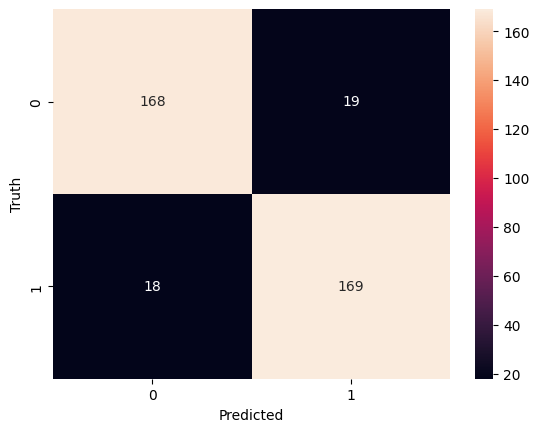

In [39]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [40]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       187
           1       0.90      0.90      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [1]:
inference = [
    'The aroma of freshly baked cookies wafted through the house, enticing everyone to gather in the kitchen, eagerly waiting for them to cool down',
    'The wind whispered through the trees',
    'The snowflakes gently fell from the sky',
    'The sun slowly descended behind the horizon, casting a warm, golden glow over the tranquil meadow dotted with vibrant wildflowers',
    "The colorful balloons floated in the air"
]
model.predict(inference)

NameError: ignored

In [ ]:
#From the inference above, more than 0.5 means it is spam otherwise not spam